## 1. Import Data

In [1]:
import pickle
import gzip
import numpy as np
import os
import cv2

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

## 1.1 Load Data

In [6]:
# load data
train_data = load_zipped_pickle("./task3/train.pkl")
test_data = load_zipped_pickle("./task3/test.pkl")
samples = load_zipped_pickle("./task3/sample.pkl")



数据结构：  
    train_data[1-65]包含65个病人的数据, 前46个是amateur数据， 后19个是expert数据  
    train_data[1]['video','label','dataset'...] , video是图片数组， label是MV mask，dataset代表是amateur还是expert  
    train_data[1]['video'] shape: [IMG_WIDTH, IMG_HEIGHT, FRAME NUM]， label也一样

In [6]:
# test_img = train_data[60]['label'][:,:,24]
# zero_img = np.zeros(test_img.shape)
# zero_img[test_img] = 255
# zero_img_resize = cv2.resize(zero_img, (1000,1000))
# zero_img.shape

In [7]:
# cv2.imshow("mask", zero_img_resize)
  
# cv2.waitKey(0) 

# cv2.destroyAllWindows() 

## 1.2 Data pre-processing

In [7]:
# 样本图片大小
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

In [8]:
# 找到含有标记的帧
def is_labeled(mask_list):
    
    label_index = []
    for i in range((mask_list).shape[2]):
        if(True in mask_list[:,:,i]):
            label_index.append(i)
            continue
    return np.array(label_index)

def image_size_normalize(raw_data, size):
    #选出有标记的图片并resize到相应尺寸
    img_width, img_height, img_channel = size
    
    labeled_img_list = []
    mask_list = []
    
    for patient_i in range(len(raw_data)):

        img_i = raw_data[patient_i]['video'] # Shape: [IMG_WIDTH1, IMG_HEIGHT1, Frame_Num1]
        mask_i = raw_data[patient_i]['label']
        label_index = is_labeled(mask_i)
        labeled_img_i = img_i[:,:,label_index]
        labeled_mask_i = mask_i[:,:,label_index]
        
        for frame_j in range(labeled_mask_i.shape[2]):
            img_j = labeled_img_i[:,:,frame_j] # [IMG_WIDTH2, IMG_HEIGHT2, Frame_Num2]
            mask_j = labeled_mask_i[:,:,frame_j]
            mask_j_digi = np.zeros(mask_j.shape)
            mask_j_digi[mask_j] = 1
            if(img_j.shape[0]!= IMG_WIDTH or img_j.shape[1]!= IMG_HEIGHT):
                img_j = cv2.resize(img_j,(img_width, img_height))
                mask_j_digi = cv2.resize(mask_j_digi,(img_width, img_height))
            labeled_img_list.append(img_j)
            mask_list.append(mask_j_digi)
            
    return np.array(labeled_img_list).reshape(-1,img_width, img_height, img_channel),np.array(mask_list).reshape(-1,img_width, img_height, 1)

In [10]:
# 从训练集中选出所有label过的图像并resize到指定大小
img_labeled, mask = image_size_normalize(train_data, (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))  # OutPut Shape: [Labeled_Frame_Num, IMG_WIDTH2, IMG_HEIGHT2, IMG_CHANNEL]

## 2 U-Net

## 2.1Model Definition 

In [10]:
# for i in range(len(train_data)):
#     print(train_data[i]['dataset'])

In [13]:
# for i in range(len(train_data)):
#     print(len(is_labeled(train_data[i]['label'])))

In [11]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from tqdm import tqdm
# from skimage.io import imread, imshow
# from skimage.transform import resize
import matplotlib.pyplot as plt
import random

In [12]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [13]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2021-12-22 17:00:54.113022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## 2.2 Train

In [14]:
results = model.fit(img_labeled, mask, batch_size=10, epochs=10)

Epoch 1/10
20/20 [==============================] - 68s 3s/step - loss: 0.2578 - accuracy: 0.9640
Epoch 2/10
20/20 [==============================] - 62s 3s/step - loss: 0.0718 - accuracy: 0.9883
Epoch 3/10
20/20 [==============================] - 66s 3s/step - loss: 0.0415 - accuracy: 0.9883
Epoch 4/10
20/20 [==============================] - 55s 3s/step - loss: 0.0294 - accuracy: 0.9883
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 0.0226 - accuracy: 0.9883
Epoch 6/10
20/20 [==============================] - 52s 3s/step - loss: 0.0217 - accuracy: 0.9883
Epoch 7/10
20/20 [==============================] - 52s 3s/step - loss: 0.0197 - accuracy: 0.9883
Epoch 8/10
20/20 [==============================] - 54s 3s/step - loss: 0.0176 - accuracy: 0.9887
Epoch 9/10
20/20 [==============================] - 53s 3s/step - loss: 0.0171 - accuracy: 0.9893
Epoch 10/10
20/20 [==============================] - 52s 3s/step - loss: 0.0163 - accuracy: 0.9897


In [18]:
img_labeled

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[2],
         [2],
         [1],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[1],
         [1],
         [0],
         ...,
         [0],


In [11]:
# def evaluate(predictions, targets):
#     ious = []
#     for p, t in zip(predictions, targets):
# #         assert p['name'] == t['name']
# #         prediction = np.array(p['prediction'], dtype=bool)
# #         target = np.array(t['label'], dtype=bool)

#         assert targets.shape == predictions.shape
#         overlap = predictions*targets
#         union = predictions + targets

#         ious.append(overlap.sum()/float(union.sum()))
    
# #     print("Median IOU: ", np.median(ious))
#     return(np.median(ious))
# # evaluate(y_pred,y_test)

In [16]:
def evaluate(predictions, targets):
    ious = []
    for i in range(predictions.shape[0]):
#         assert p['name'] == t['name']
#         prediction = np.array(p['prediction'], dtype=bool)
#         target = np.array(t['label'], dtype=bool)
        p = np.array(predictions[i,], dtype=bool)
        t = np.array(targets[i], dtype=bool)
        # assert targets.shape == predictions.shape
        overlap = p*t
        union = p + t

        ious.append(overlap.sum()/float(union.sum()))
        print(overlap.sum()/float(union.sum()))
#     print("Median IOU: ", np.median(ious))
    return(np.median(ious))
# evaluate(y_pred,y_test)

## cross validation

In [17]:
from sklearn.model_selection import KFold
import sklearn
scores = []
kf = KFold(n_splits=5, shuffle=True)
x_select = img_labeled
y_select = mask
for train_idx, test_idx in kf.split(x_select):
    x_train = x_select[train_idx]
    y_train = y_select[train_idx]
    x_test = x_select[test_idx]
    y_test = y_select[test_idx]
    # model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
#     s = r2_score(y_test.ravel(), y_pred.ravel())
    y_pred_bool = np.zeros(y_pred.shape).astype(bool)
    y_test_bool= np.zeros(y_pred.shape).astype(bool)
    y_pred_bool[y_pred>0.5] = True
    y_test_bool[y_test>0.5] = True
    s= evaluate(y_pred,y_test)
    print('score: ', s)
    scores.append(s)

scores

0.0102081298828125
0.0113067626953125
0.0211181640625
0.01416015625
0.01190185546875
0.011749267578125
0.010528564453125
0.01019287109375
0.0135345458984375
0.0118408203125
0.01251220703125
0.015655517578125
0.0139312744140625
0.01275634765625
0.018402099609375
0.013427734375
0.0147705078125
0.01312255859375
0.014892578125
0.01385498046875
0.0167236328125
0.016815185546875
0.01739501953125
0.018218994140625
0.0160675048828125
0.012847900390625
0.011810302734375
0.00714111328125
0.007293701171875
0.0054931640625
0.008148193359375
0.0068206787109375
0.0077362060546875
0.00634765625
0.0055694580078125
0.0113525390625
0.006195068359375
0.0084381103515625
0.0042572021484375
score:  0.01190185546875
0.011810302734375
0.01409912109375
0.0159912109375
0.021942138671875
0.0132598876953125
0.009979248046875
0.008941650390625
0.006591796875
0.0110931396484375
0.0153656005859375
0.01397705078125
0.019561767578125
0.0135498046875
0.0112457275390625
0.0130615234375
0.0163116455078125
0.0131225585937

[0.01190185546875,
 0.0128631591796875,
 0.011962890625,
 0.0098419189453125,
 0.0108489990234375]

In [25]:
y_pred_thresholded = y_pred > 0.5

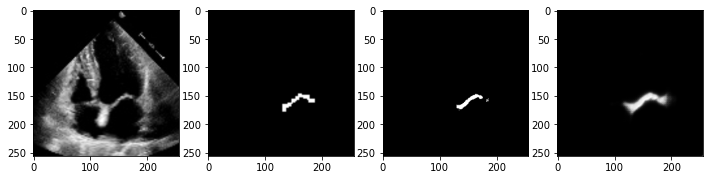

In [47]:
import random

image_number = random.randint(0, len(x_test)-1)
plt.figure(figsize=(12, 6))
plt.subplot(141)
plt.imshow(x_test[image_number], cmap='gray')
plt.subplot(142)
plt.imshow(y_test[image_number], cmap='gray')
plt.subplot(143)
plt.imshow(y_pred_thresholded[image_number], cmap='gray')
plt.subplot(144)
plt.imshow(y_pred[image_number], cmap='gray')
plt.show()

In [18]:
x_test.shape

(39, 256, 256, 1)

In [19]:
y_pred.shape

(39, 256, 256, 1)

In [20]:
mask_output = y_pred[0,:,:,0]

mask_truth = y_test[0,:,:,0]


img = x_test[0,:,:,0]
img_output = img
img_output[mask_output>0.5] = 255
img_output[mask_output<0.5] = 0

img_truth = img
img_truth[mask_truth>0.5] = 255
img_truth[mask_truth<0.5] = 0

print(img_output[mask_output>0.5].shape)
print(img_truth[mask_truth>0.5].shape)

img_difference = np.zeros(img.shape).astype(np.uint8)
img_difference[np.logical_and(mask_truth>0.5, mask_output<=0.5)] = 255


(225,)
(371,)


In [21]:
verlap = (mask_truth>0.5)*(mask_output>0.5)
union = (mask_truth>0.5) + (mask_output>0.5)
verlap.sum()/float(union.sum())

0.46078431372549017

In [23]:
cv2.imwrite('./img/img_overfitting1.png',img_output)
cv2.imwrite('./img/img_truth1.png',img_truth)
cv2.imwrite('./img/img_difference1.png',img_difference)

True

In [41]:
mask_true = np.zeros(mask_output.shape, dtype=bool)
mask_true[y_test[0,:,:,0]>0.5] = True

In [43]:
overlap = mask_true*mask_true
union = mask_true + mask_true

overlap.sum()/float(union.sum())

1.0

In [ ]:
evaluate(predictions, targets)

In [28]:

cv2.imwrite('./img/img_overfitting.png',img_output)

True

In [48]:
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

print(jaccard_similarity(y_test.ravel(),y_pred.ravel()))

1.363456015590665e-06


In [51]:
def correlation(a,b):
    set_a = set(a)
    set_b = set(b)
    unions = len(set_a.union(set_b))
    intersections = len(set_a.intersection(set_b))
    return 1. * intersections / unions
correlation(y_test.ravel(),y_pred.ravel())

1.363456015590665e-06

In [61]:
# def evaluate(predictions, targets):
#     ious = []
#     for p, t in zip(predictions, targets):
# #         assert p['name'] == t['name']
# #         prediction = np.array(p['prediction'], dtype=bool)
# #         target = np.array(t['label'], dtype=bool)

#         assert targets.shape == predictions.shape
#         overlap = predictions*targets
#         union = predictions + targets

#         ious.append(overlap.sum()/float(union.sum()))
    
# #     print("Median IOU: ", np.median(ious))
#     return(np.median(ious))
# # evaluate(y_pred,y_test)

In [36]:
import pandas as pd
pd.DataFrame(y_test.flatten()).to_csv("C:/Users/Junling_W/Desktop/y_test",index = False)

In [39]:

pd.DataFrame(mask.flatten()).to_csv("C:/Users/Junling_W/Desktop/mask.csv",index = False)

In [37]:

pd.DataFrame(y_pred.flatten()).to_csv("C:/Users/Junling_W/Desktop/y_pred",index = False)

In [30]:
y_pred

array([[[[3.10724545e-02],
         [2.87532527e-03],
         [1.71948894e-04],
         ...,
         [1.05960009e-06],
         [3.94177696e-05],
         [6.05358393e-04]],

        [[7.92971067e-03],
         [2.14057698e-04],
         [1.89728257e-06],
         ...,
         [5.40964495e-10],
         [8.54724149e-08],
         [4.10475441e-05]],

        [[2.16715271e-03],
         [5.16138152e-06],
         [2.67924332e-08],
         ...,
         [5.60880444e-13],
         [4.97218844e-09],
         [2.13269658e-07]],

        ...,

        [[3.13859346e-04],
         [2.30226897e-06],
         [2.50392080e-08],
         ...,
         [1.24494581e-10],
         [2.10939373e-08],
         [5.77700303e-05]],

        [[5.12614800e-03],
         [1.37194686e-04],
         [1.80893471e-06],
         ...,
         [2.76161991e-08],
         [1.36795870e-06],
         [2.34772029e-04]],

        [[1.19859129e-02],
         [2.03054908e-04],
         [7.49339306e-05],
         ...,
 

In [41]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
s = r2_score(y_test.ravel(), y_pred.ravel())

In [42]:
s

0.5186819779734481

## 2.3 MODEL PREDICT

In [16]:
# 从训练集中选出所有label过的图像并resize到指定大小
img_labeled= image_size_normalize(test_data, (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))  # OutPut Shape: [Labeled_Frame_Num, IMG_WIDTH2, IMG_HEIGHT2, IMG_CHANNEL]

KeyError: 'label'

In [ ]:
model.fit(img_labeled, mask, batch_size=10, epochs=10)

# 3 Visualization

In [18]:
import os

from PIL import Image

def video_make(name, image_list, mask_list,  img_size =(112, 112)):

    fps = 24 #视频每秒24帧
    size = img_size #需要转为视频的图片的尺寸

    #视频保存在当前目录下

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')    
    video = cv2.VideoWriter(name+".avi",fourcc, fps,size, False)
    #draw stuff that goes on every frame here
    for frame_i in range(image_list.shape[2]):
        img = (image_list[:,:,frame_i])
        mask = mask_list[:,:,frame_i]
        img[mask] = 255
        img_mat = cv2.Mat(img)
        video.write(img)
    video.release()


## 4 Conclusion（things to be done for improvement）  
4.1 如上可见，随着epoch增加, accuracy波动很大，网络不是很work。 不清楚是数据量不够，网络复杂度不够， 还是iter比较小（纯ml小白）  
    如果是数据量不够， 或许需要用tracking的办法增加数据量
4.2 需要做cross-validation的预测版本
4.3 由于数据集中， 属于MV的像素点很少，和类别不平衡问题很像， 最好能增大 MV区域误识别的错误权重
4.4 预测的可视化实现